In [1]:
# Last updated: May 14, 2024

## Overview

- Learn how to (lazy) load catalogs
- Learn how to use those catalogs and perform crossmatching with existing `LSDB` catalogs
- Save the results

In [2]:
# Standard library imports
import os

# Third-party imports
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import rcParams
import astropy.units as u

# Local library-specific imports
import lsdb
from lsdb.core.search import BoxSearch, ConeSearch, PolygonSearch
from hipscat.inspection import plot_pixels
from hipscat.io.file_io import read_parquet_metadata

# Jupyter-specific settings and magic commands
%matplotlib inline
%config InlineBackend.figure_format = "retina"

# Configuration settings
rcParams['savefig.dpi'] = 550
rcParams['font.size'] = 20
plt.rc('font', family='serif')
mpl.rcParams['axes.linewidth'] = 2

print(f'Version of lsdb is {lsdb.__version__}')

Version of lsdb is 0.2.3


In [3]:
catalogs_dir = "https://epyc.astro.washington.edu/~lincc-frameworks/hipscat_surveys"

# Gaia
gaia_path = f"{catalogs_dir}/gaia_dr3/gaia"

# ZTF
ztf_object_path = f"{catalogs_dir}/ztf/ztf_dr14/"
ztf_source_path = f"{catalogs_dir}/ztf/ztf_zource/"

In [4]:
%%time

# Load lite (coarse) version of Gaia DR3 (it has data from all the HEALPix intersecting with the cone)
cone_search = ConeSearch(ra=-60, dec=20.5, radius_arcsec=1*3600)
gaia_lite = lsdb.read_hipscat(gaia_path, columns=["ra", "dec"], search_filter=cone_search)

# Load Gaia data for the same cone (keeps only data inside the cone)
gaia = lsdb.read_hipscat(gaia_path).cone_search(ra=-60, dec=20.5, radius_arcsec=1*3600, fine=True)

CPU times: user 877 ms, sys: 131 ms, total: 1.01 s
Wall time: 3.3 s


## Reading Parquet Metadata

HiPSCat uses the Parquet file format to store catalogs. Parquet is a binary columnar data format, which means that information is efficiently encoded and compressed in binary format on disk, and is stored column wise in a way which allows efficiently loading only a subset of the columns. With each column, Parquet stores the column's metadata, including the column's name and data type.

Parquet also supports large datasets being partitioned into multiple files that are easier to work with individually. With a partitioned dataset, like HiPSCat uses, there are metadata files at the root folder containing the partitioned files that store the combined and common metadata of each of the individual partition files metadata. Here, we can read this `_common_metadata` which includes the schema of the dataset, consisting of the column metadata for all the columns in the dataset.

In [5]:
list(read_parquet_metadata(os.path.join(gaia_path, "_common_metadata")).schema)[:2]

[<ParquetColumnSchema>
   name: _hipscat_index
   path: _hipscat_index
   max_definition_level: 1
   max_repetition_level: 0
   physical_type: INT64
   logical_type: Int(bitWidth=64, isSigned=false)
   converted_type (legacy): UINT_64,
 <ParquetColumnSchema>
   name: solution_id
   path: solution_id
   max_definition_level: 1
   max_repetition_level: 0
   physical_type: INT64
   logical_type: None
   converted_type (legacy): NONE]

## Lazy Operations

When working with large datasets, there is too much data to be loaded into memory at once. To get around this, LSDB uses the HiPSCat format which partitions a catalog into HEALPix cells and works on one partition at a time. This also allows the computation to be parallelized to work on multiple partitions at once. In order to efficiently carry out pipelines of operations though, it's better to batch operations so that multiple operations can be done back to back on the same partition instead of having to load and save each partition from storage after every operation.

For this reason, operations in LSDB are performed 'lazily'. This means when a catalog is read using `read_hipscat`, the actual catalog data isn't being read from storage. Instead, it only loads the metadata such as the column schema and the HEALPix structure of the partitions. When an operation like `cone_search` is called on a catalog, the data is not actually loaded and operated on when the line of code is executed. Instead, the catalog keeps track of the operations that it needs to perform so the entire pipeline can be efficiently run later. This also allows us to optimize the pipeline by only loading the partitions that are necessary. For example when performing a cone search like we do here, we only need the partitions that have data within the cone.

So when we look at a catalog that has been lazy loaded we see the DataFrame without the data, just the columns and the number of partitions (including the HiPSCat index of each partition encoding which HEALPix cell the partition is in). 

In [6]:
gaia_lite

,ra,dec
npartitions=4,,
3645663898356416512,double[pyarrow],double[pyarrow]
3646789798263259136,...,...
3652700772774182912,...,...
3653545197704314880,...,...
18446744073709551615,...,...


To load the data and perform the operations, call `compute()` which will load the necessary data and perform all the operations that have been called, and return a Pandas DataFrame with the results.

In [7]:
gaia_lite_computed = gaia_lite.compute()

In [8]:
gaia_lite_computed

,ra,dec
_hipscat_index,,
3645663899514044416,299.533159,18.21176
3645663900969467904,299.530223,18.212685
3645663901456007168,299.529506,18.212921
3645663901607002112,299.531427,18.212798
3645663901678305280,299.53144,18.212959
...,...,...
3654671088115253248,299.533488,23.313408
3654671088761176064,299.533875,23.314336
3654671089591648256,299.52758,23.311197


## HiPSCat Partitioning

To make it easier and more efficient to perform operations in parallel, HiPSCat partitions contain roughly the same number of rows. This is done by using different HEALPix pixel sizes for different parts of the sky depending on the density of sources. This means catalogs with more rows will have smaller pixels for each partition, and so will have more partitions overall. We can see this below with the ZTF object and source catalogs, where the source catalog with many more data points has more partitions to keep the size of each partition consistent.

In [9]:
%%time
ztf_object = lsdb.read_hipscat(ztf_object_path, columns=["ra", "dec"]) # ZTF Object
ztf_source = lsdb.read_hipscat(ztf_source_path, columns=["ra", "dec"]) # ZTF Source

CPU times: user 1.58 s, sys: 174 ms, total: 1.75 s
Wall time: 3.61 s


In [10]:
ztf_object

,ra,dec
npartitions=2352,,
0,double[pyarrow],double[pyarrow]
18014398509481984,...,...
...,...,...
13830554455654793216,...,...
18446744073709551615,...,...


In [11]:
ztf_source

,ra,dec
npartitions=41679,,
0,double[pyarrow],double[pyarrow]
4503599627370496,...,...
...,...,...
13833932155375321088,...,...
18446744073709551615,...,...


We can see this difference in partition pixel sizes by plotting the HEALPix pixels of the partitions in the catalogs.

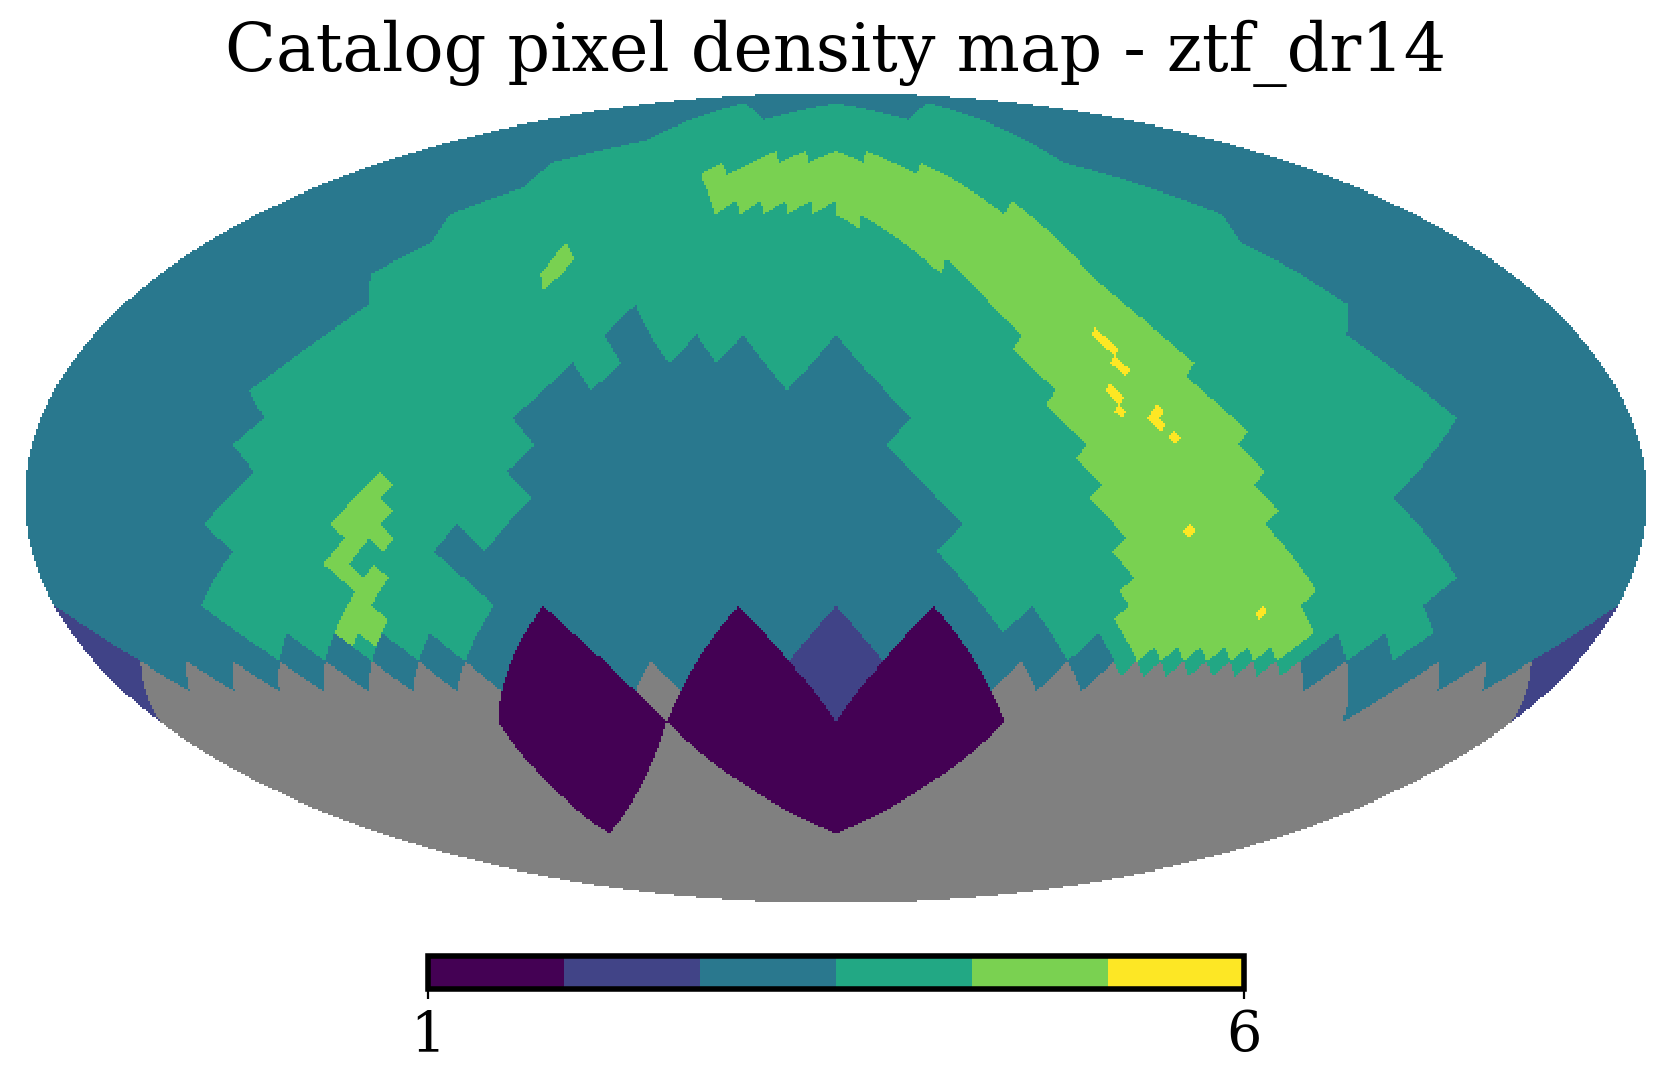

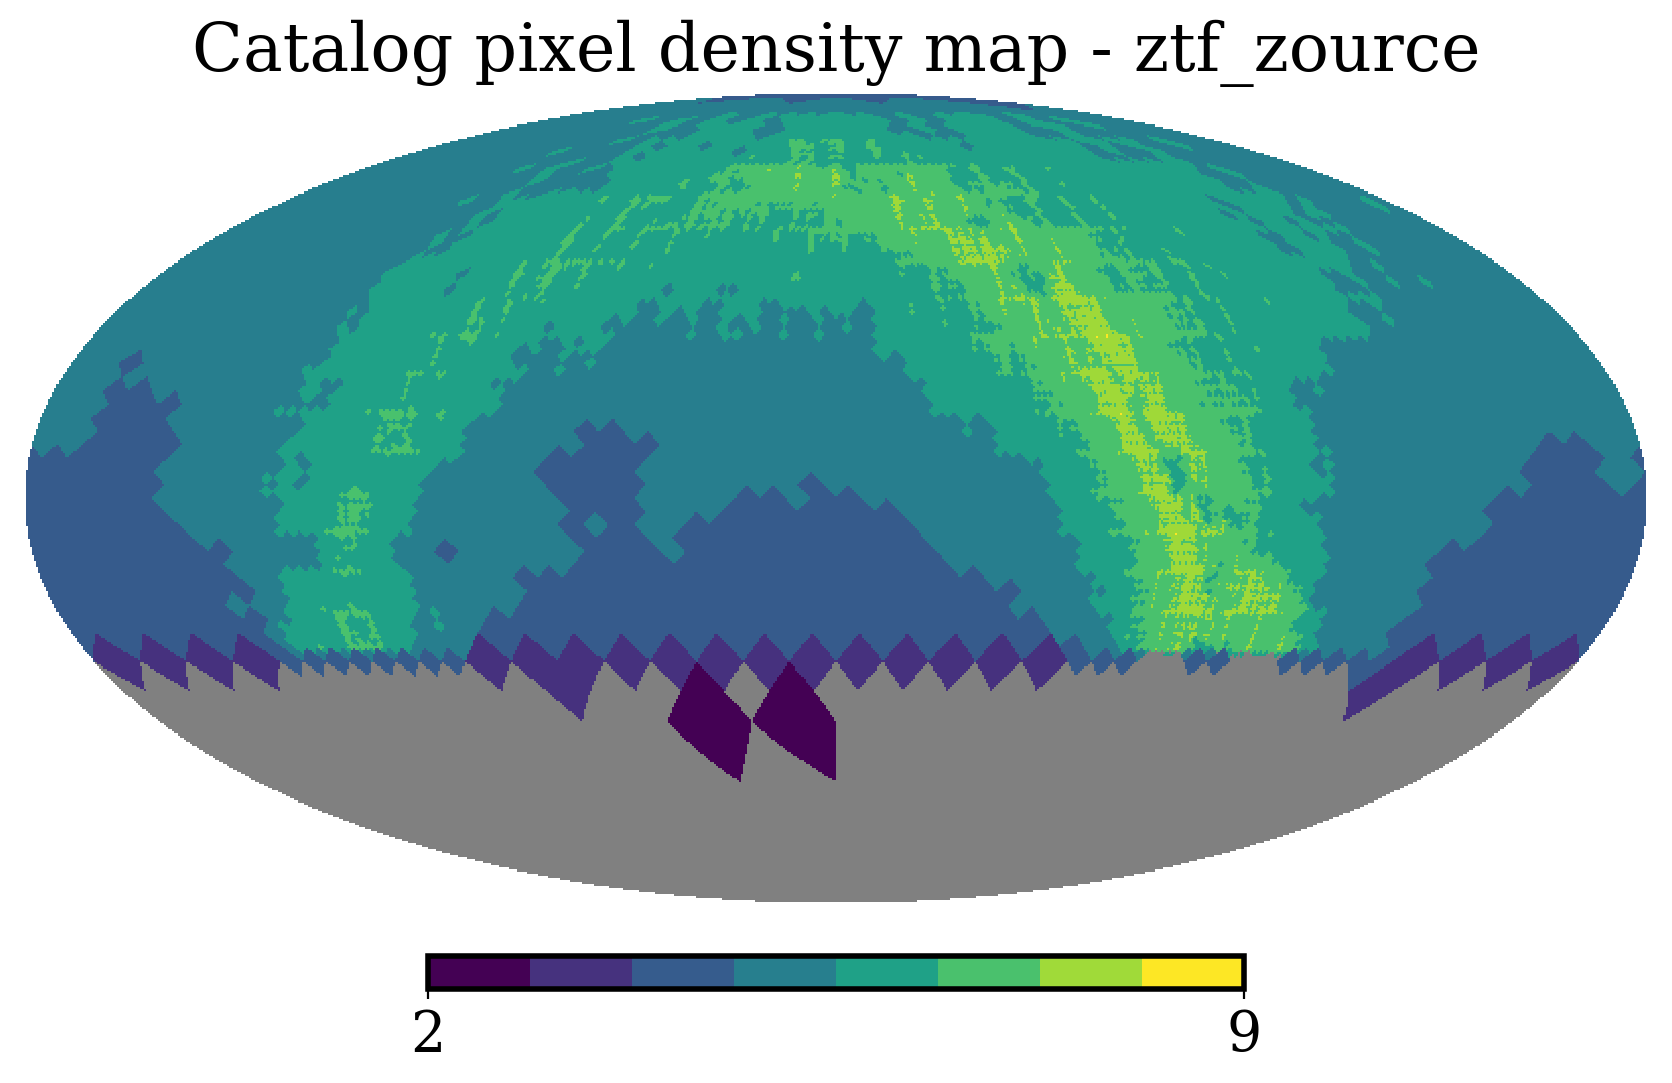

In [12]:
# Plot the Pixel Density Maps for Gaia and ZTF

#plot_pixels(gaia.hc_structure)
plot_pixels(ztf_object.hc_structure)
plot_pixels(ztf_source.hc_structure)

## The `Head` function

For large operations we might want to see a small subset of the computed final data without doing the full computation. Like pandas, we can use the `head` operation to compute the first n rows of the final dataframe without computing the whole dataset.

In [13]:
# Cross-match Gaia and ZTF
%time 
xmatch_object = gaia_lite.crossmatch(ztf_object)

xmatch_object.head(5)

CPU times: user 5 µs, sys: 1 µs, total: 6 µs
Wall time: 12.9 µs


/home/camposandro/.local/lib/python3.11/site-packages/lsdb/dask/crossmatch_catalog_data.py:121: RuntimeWarning: Right catalog does not have a margin cache. Results may be incomplete and/or inaccurate.
  warnings.warn(


,ra_gaia,dec_gaia,ra_ztf_dr14,dec_ztf_dr14,_dist_arcsec
_hipscat_index,,,,,
3645663899514044416,299.533159,18.21176,299.533154,18.211779,0.072382
3645663900969467904,299.530223,18.212685,299.530212,18.212697,0.056859
3645663901456007168,299.529506,18.212921,299.52948,18.212954,0.150216
3645663901607002112,299.531427,18.212798,299.531427,18.212937,0.502792
3645663901678305280,299.53144,18.212959,299.531427,18.212937,0.088326


Here we load the ztf object catalog again, this time with all the columns that we'll need to perform the analysis later

In [14]:
%%time
# load ZTF with all columns here
ztf_object_full = lsdb.read_hipscat(ztf_object_path)

CPU times: user 158 ms, sys: 27.7 ms, total: 185 ms
Wall time: 1.03 s


In [15]:
%%time
# crossmatch ZTF + Gaia
_all_sky_object = gaia.crossmatch(ztf_object_full).query(
    "nobs_g_ztf_dr14 > 50 and nobs_r_ztf_dr14 > 50 and \
    parallax_gaia > 0 and parallax_over_error_gaia > 5 and \
    teff_gspphot_gaia > 5380 and teff_gspphot_gaia < 7220 and logg_gspphot_gaia > 4.5 \
    and logg_gspphot_gaia < 4.72 and classprob_dsc_combmod_star_gaia > 0.5")

/home/camposandro/.local/lib/python3.11/site-packages/lsdb/dask/crossmatch_catalog_data.py:121: RuntimeWarning: Right catalog does not have a margin cache. Results may be incomplete and/or inaccurate.
  warnings.warn(


CPU times: user 434 ms, sys: 5.27 ms, total: 439 ms
Wall time: 441 ms


In [16]:
%%time
total = _all_sky_object.compute()

CPU times: user 13 s, sys: 5.97 s, total: 19 s
Wall time: 8.89 s


In [17]:
total.head(5)

,solution_id_gaia,designation_gaia,source_id_gaia,random_index_gaia,ref_epoch_gaia,ra_gaia,ra_error_gaia,dec_gaia,dec_error_gaia,parallax_gaia,...,nobs_g_ztf_dr14,nobs_r_ztf_dr14,nobs_i_ztf_dr14,mean_mag_g_ztf_dr14,mean_mag_r_ztf_dr14,mean_mag_i_ztf_dr14,Norder_ztf_dr14,Dir_ztf_dr14,Npix_ztf_dr14,_dist_arcsec
_hipscat_index,,,,,,,,,,,,,,,,,,,,,
3646067079259357184,1636148068921376768,Gaia DR3 1823033542087957248,1823033542087957248,681413300,2016.0,300.344658,0.028663,19.554414,0.027776,0.668537,...,404,1009,0,16.879663,16.132171,<NA>,5,0,3238,0.077723
3646067849677504512,1636148068921376768,Gaia DR3 1823033920045097728,1823033920045097728,606871238,2016.0,300.426663,0.014488,19.587297,0.014479,0.97283,...,101,373,0,15.232552,14.680055,<NA>,5,0,3238,0.069844
3646068328969011200,1636148068921376768,Gaia DR3 1823034156246247424,1823034156246247424,987360779,2016.0,300.422159,0.042693,19.608572,0.041722,0.350765,...,94,362,0,17.727001,16.956606,<NA>,5,0,3238,0.03968
3646079368708489216,1636148068921376768,Gaia DR3 1823039658126194176,1823039658126194176,1633982299,2016.0,300.549673,0.041812,19.653736,0.039993,0.485155,...,352,953,0,17.264943,16.503687,<NA>,5,0,3238,0.067978
3646079377201954816,1636148068921376768,Gaia DR3 1823039692480622976,1823039692480622976,367753372,2016.0,300.5315,0.037491,19.641191,0.035262,0.380807,...,396,1008,0,17.493767,16.728938,<NA>,5,0,3238,0.049519


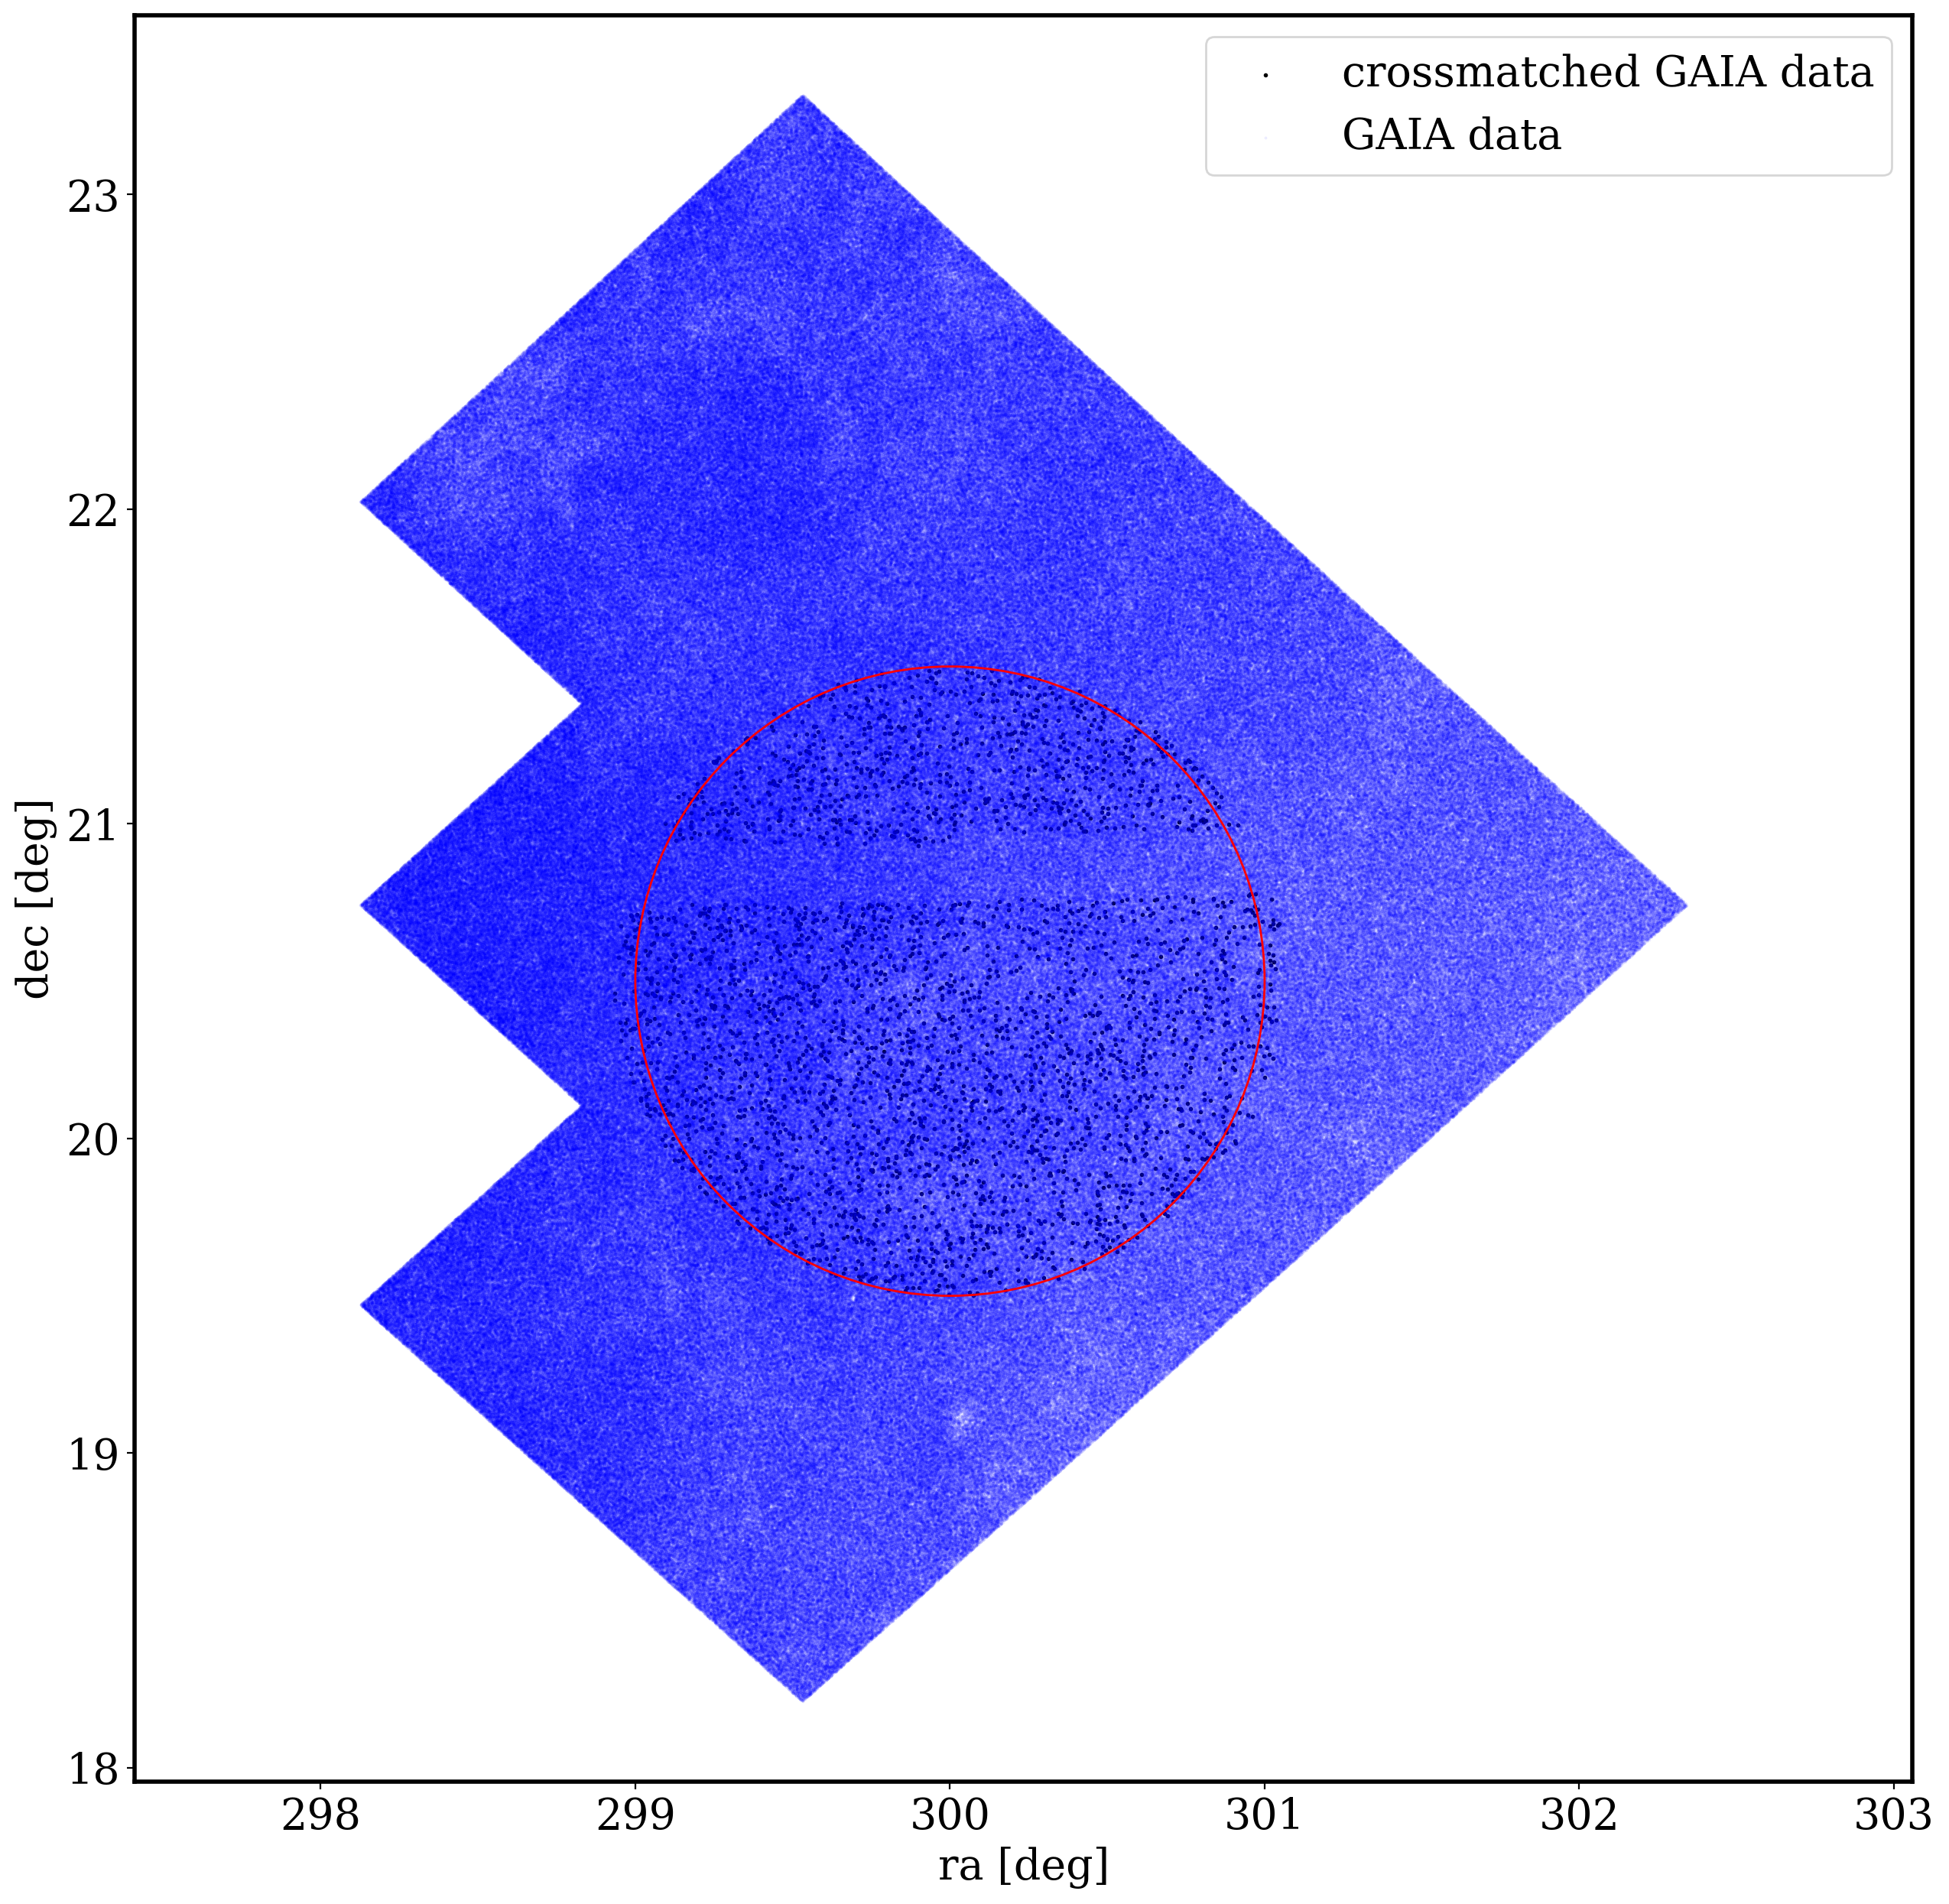

In [18]:
plt.figure(figsize=(15,15))
plt.scatter(total['ra_gaia'].values, total['dec_gaia'].values, color='black', s=1, label='crossmatched GAIA data')
plt.scatter(gaia_lite_computed['ra'], gaia_lite_computed['dec'], color='blue', s=0.1, alpha=0.1, label='GAIA data')

# Create a circle patch
circle = patches.Circle((300, 20.5), 1, edgecolor='red', facecolor='lightblue', fill=False)

plt.axis('equal')
plt.gca().add_patch(circle)
plt.xlabel('ra [deg]')
plt.ylabel('dec [deg]')
plt.legend()

In [19]:
# export crossmatched data to disk
_all_sky_object.to_hipscat(base_catalog_path="ztf_x_gaia", catalog_name="ztf_x_gaia")

In [20]:
!ls

Notebook_1_Load_and_Xmatch.ipynb	  README.md
Notebook_2_Basic_Time_Domain.ipynb	  ztf_x_gaia
Notebook_3_Vizier_LSDB_Interaction.ipynb
